In [1]:
import sys
sys.path.insert(0, '../../scripts/')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# import required packages
import re
import pandas as pd
import numpy as np
from PIL import Image

# preprocess
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

# plots
from wordcloud import WordCloud
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# local scripts
from text_utils import preprocess_corpus, untokenize_document

In [3]:
# read the dataset into a dataframe
df = pd.read_csv('../../data/data.csv')

# dataset shape: (rows, columns)
display(df.shape)

# first 5 datapoints
df.head()

(5842, 2)

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


neutral     3130
positive    1852
negative     860
Name: Sentiment, dtype: int64


null counts
Sentence     0
Sentiment    0
dtype: int64


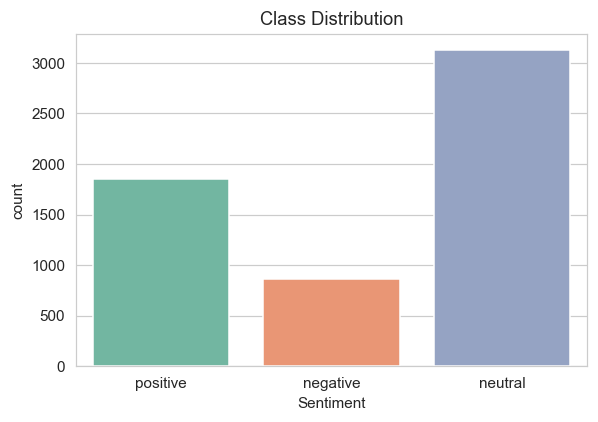

In [4]:
# class distribution
print(df['Sentiment'].value_counts())

# check null value counts
print('\n\nnull counts')
print(df.isnull().sum())

# plot the class distribution
plt.figure(dpi=110)
chart = sns.countplot(x="Sentiment", data=df, palette="Set2")
axes = chart.axes
axes.set_title('Class Distribution')
axes.set_xlabel('Sentiment')
plt.show()

In [5]:
# duplicate sentences
df[df['Sentence'].duplicated()]

,Sentence,Sentiment
266,Finnish GeoSentric 's net sales decreased to E...,neutral
283,Sales in Finland decreased by 10.5 % in Januar...,negative
349,Full-year operating result for 2008 was 3.6 mi...,negative
387,"Making matters more difficult , the company sa...",negative
496,"Antti Orkola , president of Kemira GrowHow 's ...",negative
...,...,...
5827,"( ADPnews ) - Oct 21 , 2009 - Finland-based IT...",negative
5831,Finnish developer and manufacturer of mobile p...,negative
5832,Operating profit fell to EUR 38.1 mn from EUR ...,negative
5837,RISING costs have forced packaging producer Hu...,negative


In [6]:
# extract indices of duplicate sentences
duplicate_indices = df[df['Sentence'].duplicated()].index.to_list()

dup_df = None

# extract each set of duplicate sentences
for index in duplicate_indices:
    dup_df = pd.concat([dup_df, df[df['Sentence'] == df['Sentence'].loc[index]]])

dup_df

,Sentence,Sentiment
66,Finnish GeoSentric 's net sales decreased to E...,negative
266,Finnish GeoSentric 's net sales decreased to E...,neutral
163,Sales in Finland decreased by 10.5 % in Januar...,neutral
283,Sales in Finland decreased by 10.5 % in Januar...,negative
195,Full-year operating result for 2008 was 3.6 mi...,neutral
...,...,...
5832,Operating profit fell to EUR 38.1 mn from EUR ...,negative
1860,RISING costs have forced packaging producer Hu...,neutral
5837,RISING costs have forced packaging producer Hu...,negative
186,"In the building and home improvement trade , s...",negative


In [7]:
# drop the duplicate sentences with "neutral" sentiment
for index in duplicate_indices:
    temp = df[df['Sentence'] == df['Sentence'].loc[index]]
    dup_idx = temp[temp['Sentiment'] == 'neutral'].index[0]
    df = df.drop(index=dup_idx)

# reset the index
df.reset_index()
    
# verify if duplicate sentences are dropped
df[df['Sentence'].duplicated()]

,Sentence,Sentiment


neutral     2610
positive    1852
negative     860
Name: Sentiment, dtype: int64


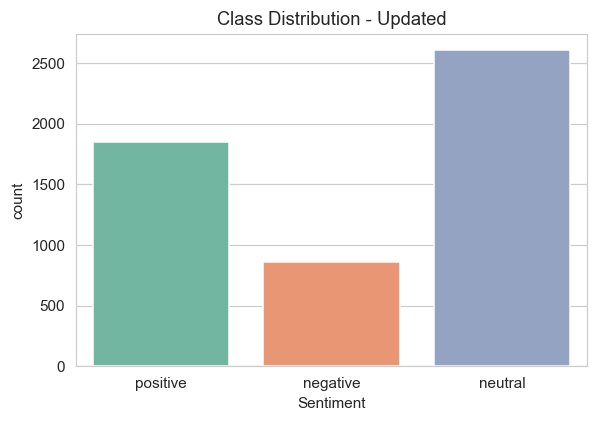

In [8]:
# class distribution after dropping duplicates
print(df['Sentiment'].value_counts())

# plot the class distribution after droping duplicates
plt.figure(dpi=110)
chart = sns.countplot(x="Sentiment", data=df, palette="Set2")
axes = chart.axes
axes.set_title('Class Distribution - Updated')
axes.set_xlabel('Sentiment')
plt.show()

In [9]:
# splitting into train-validation-test sets (60-20-20)
# performing a random split

# train-test split (80-20)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Sentiment'])

# train-validation split (80-20)
# 0.8 * 0.25 = 0.2
df_train, df_valid = train_test_split(df_train, test_size=0.25, random_state=42, stratify=df_train['Sentiment'])

# rest index
df_train.reset_index()
df_valid.reset_index()
df_test.reset_index()

# size of train-validation-test sets
print('train:',df_train.shape[0])
print('valid:',df_valid.shape[0])
print('test:',df_test.shape[0])

# saving validation set
df_valid.to_csv('../../data/valid_data.csv', index=False)

# saving test set
df_test.to_csv('../../data/test_data.csv', index=False)

train: 3192
valid: 1065
test: 1065


In [10]:
# preprocess the tweet_text column
df_train['clean_sentence'] = preprocess_corpus(df['Sentence'])

# construct clean train set
df_train_clean = df_train.loc[:,['clean_sentence', 'Sentiment']]

# save the clean train set
df_train_clean.to_csv('../../data/train_data.csv', index=False)

# first 5 cleaned datapoints
df_train_clean.head()

,clean_sentence,Sentiment
2823,upm kymmene one world leading printing paper p...,positive
685,nokia pct eur kicking morning negative territory,positive
3050,vasantha appointed managing director incap con...,neutral
827,consolidated net sale increased reach eur oper...,positive
3910,cabot export production mainly goodyear bridge...,neutral


## WordCloud: Neutral sentences
----

In [11]:
# load all the english stopwords
stop_words = stopwords.words('english')

# total stopwords
print(len(stop_words))

# first 10 stopwords
stop_words[:10]

179


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [12]:
# creating a mask for wordcloud
# mask = np.array(Image.open('../images/image.png'))
# plt.axis('off')
# plt.imshow(mask)
# plt.show()

colormap = 'Set2'

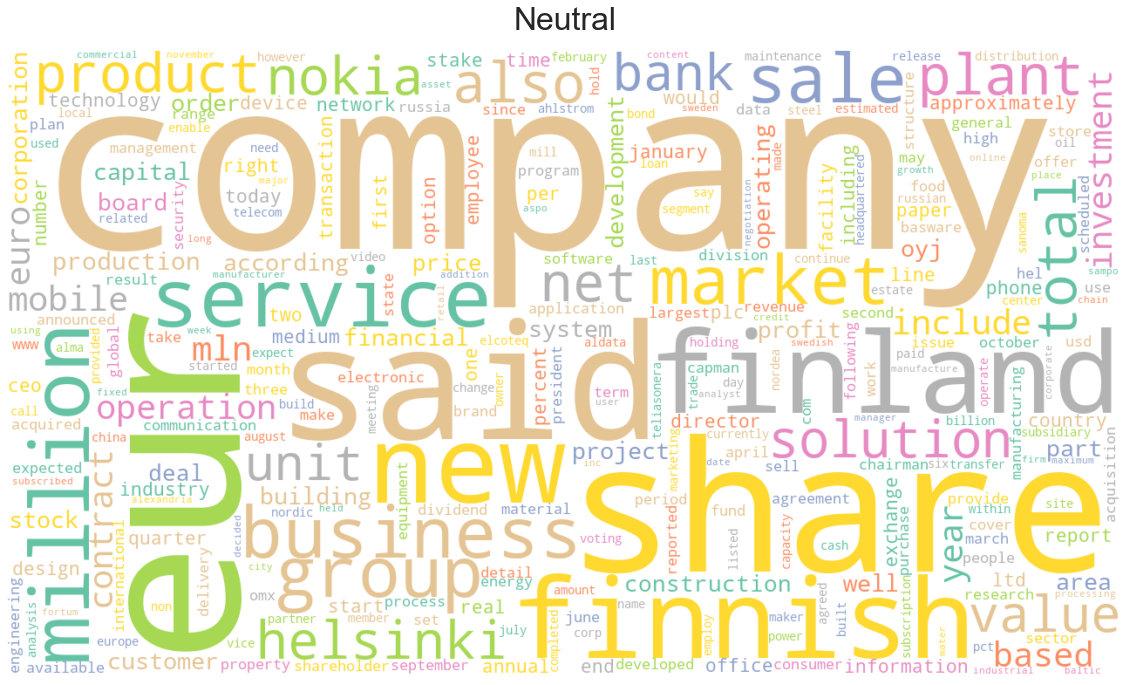

In [13]:
# wordcloud for neutral statements
plt.figure(figsize=(20,20))

wordcloud = WordCloud(
    min_font_size=5, 
    max_words=300, 
    width=1280, 
    height=720, 
    stopwords=stop_words, 
    background_color='white',
    collocations=False,
    colormap=colormap,
#     mask=mask,
#     contour_color='#1DA1F2',
#     contour_width=1
).generate(str(" ".join(df_train[df_train['Sentiment'] == 'neutral'].clean_sentence)))

plt.axis('off')
plt.title('Neutral', fontsize=32, pad=20)
plt.imshow(wordcloud, interpolation='bilinear')
# plt.savefig("../images/wordcloud-neutral.png", format="png", bbox_inches='tight', pad_inches=0)
plt.show()

## WordCloud: Positive sentences
----

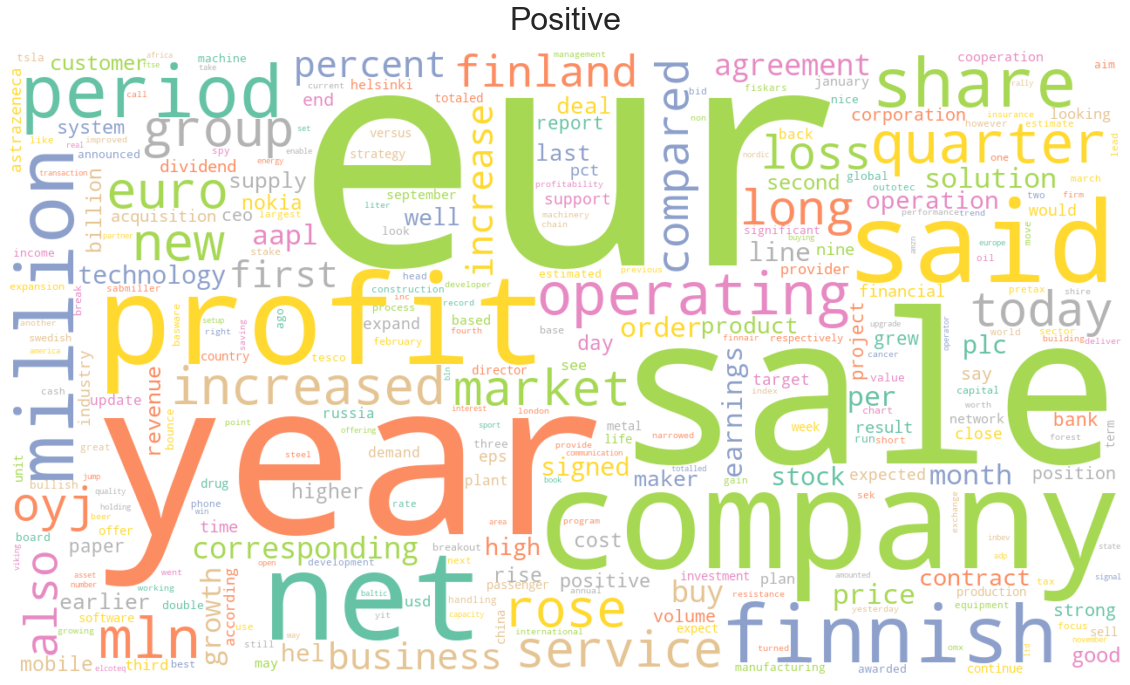

In [14]:
# wordcloud for positive statements
plt.figure(figsize=(20,20))

wordcloud = WordCloud(
    min_font_size=5, 
    max_words=300, 
    width=1280, 
    height=720, 
    stopwords=stop_words, 
    background_color='white',
    collocations=False,
    colormap=colormap,
#     mask=mask,
#     contour_color='#1DA1F2',
#     contour_width=1
).generate(str(" ".join(df_train[df_train['Sentiment'] == 'positive'].clean_sentence)))

plt.axis('off')
plt.title('Positive', fontsize=32, pad=20)
plt.imshow(wordcloud, interpolation='bilinear')
# plt.savefig("../images/wordcloud-positive.png", format="png", bbox_inches='tight', pad_inches=0)
plt.show()

## WordCloud: Negative sentences
----

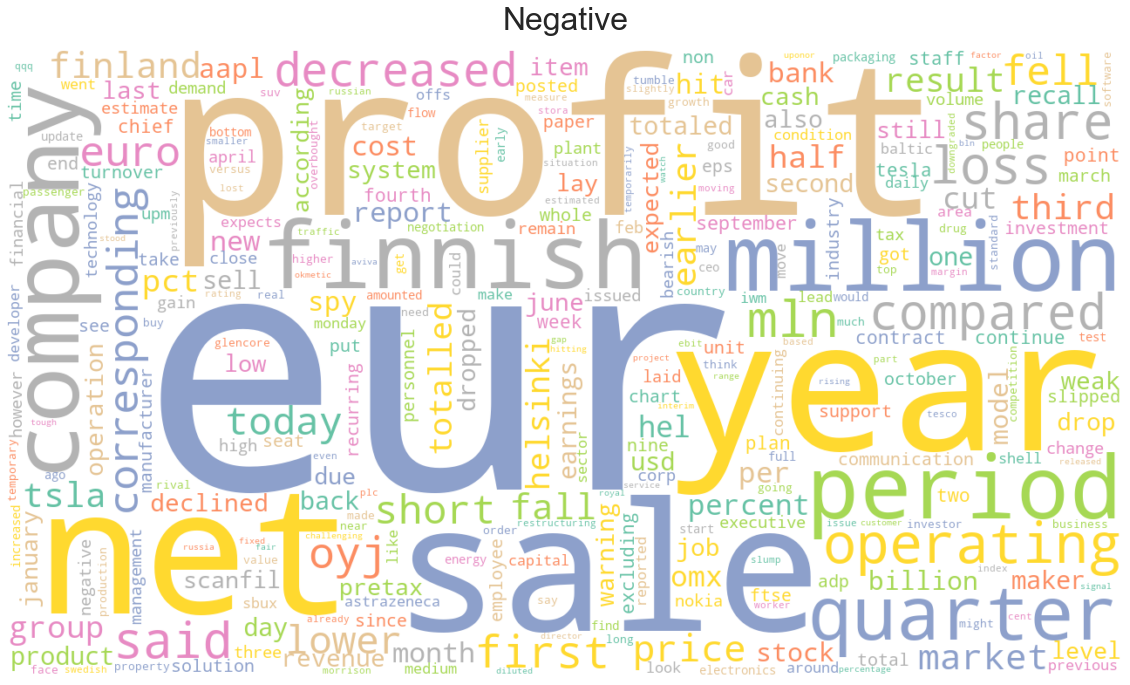

In [15]:
# wordcloud for negative statements
plt.figure(figsize=(20,20))

wordcloud = WordCloud(
    min_font_size=5, 
    max_words=300, 
    width=1280, 
    height=720, 
    stopwords=stop_words, 
    background_color='white',
    collocations=False,
    colormap=colormap,
#     mask=mask,
#     contour_color='#1DA1F2',
#     contour_width=1
).generate(str(" ".join(df_train[df_train['Sentiment'] == 'negative'].clean_sentence)))

plt.axis('off')
plt.title('Negative', fontsize=32, pad=20)
plt.imshow(wordcloud, interpolation='bilinear')
# plt.savefig("../images/wordcloud-negative.png", format="png", bbox_inches='tight', pad_inches=0)
plt.show()